# Análisis Exploratorio de los Microdatos del Censo 2017

Por **Eduardo Graells-Garrido** y Daniela Opitz. <dopitz@udd.cl>.
Actualizado: **14 de mayo de 2024**.

En este notebook muestro cómo cargar datos del Censo 2017 para generar mapas de coropletas.

Particularmente haremos tres mapas:

  * ¿Cuál es la distribución de les inmigrantes en Santiago?
  * ¿Cuál es la distribución de las personas mayores de 65 años en Santiago?
  * ¿Dónde viven más hombres o mujeres?

Los datos se han obtenido de las siguientes fuentes (y están incluidos en este repositorio):

  * [Microdatos del Censo 2017](http://www.censo2017.cl/microdatos/)
  * [Shapefile de Distritos Censales](https://github.com/justinelliotmeyers/official_chile_2017_census_boundary_shapefile)
  * [Shapefile de áreas urbanas del país](https://www.bcn.cl/siit/mapas_vectoriales/index_html)

Comencemos.

## Preámbulo


Y descargar los datos si es que estás usando Google Colab

In [1]:
try:
    import google.colab
    !curl -L -o censo2017.zip 'https://www.dropbox.com/scl/fi/gx94xhhvwm5ncilwyt0yc/censo2017.zip?rlkey=zufb4zjrbx614gep3pra5qix5&st=pl1s7cde&dl='
    !unzip -o censo2017.zip
except:
    pass

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   256    0   256    0     0    441      0 --:--:-- --:--:-- --:--:--   442
100   491    0   491    0     0    468      0 --:--:--  0:00:01 --:--:--  1371
100  267M  100  267M    0     0  34.8M      0  0:00:07  0:00:07 --:--:-- 45.5M
Archive:  censo2017.zip
  inflating: censo2017/Censo2017_Identificación_Geográfica/Microdato_Censo2017-Categorias.csv  
 extracting: censo2017/Censo2017_Identificación_Geográfica/Microdato_Censo2017-Areas.csv  
  inflating: censo2017/Censo2017_Identificación_Geográfica/Microdato_Censo2017-Regiones.csv  
  inflating: censo2017/Censo2017_Identificación_Geográfica/Microdato_Censo2017-Comunas.csv  
  inflating: censo2017/Censo2017_Identificación_Geográfica/Microdato_Censo2017-Urbano.csv  
  inflating: censo2017/Censo2017_Identificación_Geográfica/Microdato_Censo2017-Geografia.csv  
  inflat

In [2]:
try:
    import google.colab
    !curl -L -o Fira_Sans_Extra_Condensed.zip 'https://www.dropbox.com/s/82nuhtpybfpjeq9/Fira_Sans_Extra_Condensed.zip?dl=1'
    !unzip -o Fira_Sans_Extra_Condensed.zip
    import matplotlib as mpl
    mpl.font_manager.fontManager.addfont('Fira_Sans_Extra_Condensed/FiraSansExtraCondensed-Regular.ttf')
    #mpl.rc('font', family='Fira Sans Extra Condensed')
except:
    pass

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   123    0   123    0     0    992      0 --:--:-- --:--:-- --:--:--   991
100   261    0   261    0     0    606      0 --:--:-- --:--:-- --:--:--   606
100   496    0   496    0     0    587      0 --:--:-- --:--:-- --:--:--   587
100 3733k  100 3733k    0     0  2985k      0  0:00:01  0:00:01 --:--:-- 65.1M
Archive:  Fira_Sans_Extra_Condensed.zip
  inflating: __MACOSX/._Fira_Sans_Extra_Condensed  
  inflating: Fira_Sans_Extra_Condensed/FiraSansExtraCondensed-MediumItalic.ttf  
  inflating: __MACOSX/Fira_Sans_Extra_Condensed/._FiraSansExtraCondensed-MediumItalic.ttf  
  inflating: Fira_Sans_Extra_Condensed/FiraSansExtraCondensed-Italic.ttf  
  inflating: __MACOSX/Fira_Sans_Extra_Condensed/._FiraSansExtraCondensed-Italic.ttf  
  inflating: Fira_Sans_Extra_Condensed/FiraSansExtraCondensed-BlackItalic.ttf  
  inflating: __MACOS

Aquí cargamos las bibliotecas que necesitamos utilizar y configuramos el sistema.

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(font='sans-serif', context='notebook', palette='viridis')
%config InlineBackend.figure_format='retina'

# esto configura la calidad de la imagen. dependerá de tu resolución. el valor por omisión es 80
plt.rcParams["figure.dpi"] = 96
# esto depende de las fuentes que tengas instaladas en tu sistema.
plt.rcParams["font.family"] = "Fira Sans Extra Condensed"

In [4]:
pd.set_option('display.max_columns', None)

## Carga de Datos

Comencemos. Lo primero que hacemos es cargar los datos. Aquí hacemos una serie de operaciones de modo de quedarnos solamente con la región metropolitana.

Es posible que mi manera de limpiar los datos no sea la adecuada. En tal caso, por favor escríbeme un correo o abre un _issue_ en este repositorio.

In [5]:
# Cargar los datos de las manzanas del censo desde un archivo CSV
manzanas = pd.read_csv('censo2017/Censo2017_ManzanaEntidad_CSV/Censo2017_Manzanas.csv', sep=';')

manzanas.head()

REGION  PROVINCIA  COMUNA  DC  AREA  ZC_LOC  MZ_ENT  ID_ZONA_LOC  \
0       1         11    1101   1     1       1       1         7849   
1       1         11    1101   1     1       1      10         7849   
2       1         11    1101   1     1       1      11         7849   
3       1         11    1101   1     1       1      12         7849   
4       1         11    1101   1     1       1      13         7849   

      ID_MANZENT  PERSONAS HOMBRES MUJERES EDAD_0A5 EDAD_6A14 EDAD_15A64  \
0  1101011001001        15       *       *        0         0         15   
1  1101011001010        70      38      32        *         *         54   
2  1101011001011        36      21      15        *         0         28   
3  1101011001012        65      34      31        *         7         49   
4  1101011001013        39      12      27        *         *         26   

  EDAD_65YMAS INMIGRANTES PUEBLO  VIV_PART  VIV_COL  MATACEP  MATREC  \
0           0           0      0         1        2        0       0   
1          10          12     13        17        1       14       1   
2           *          11      7        15        1       10       5   
3           *          27      4        24        0       11       9   
4           7           4     17        11        2        9       0   

   MATIRREC  VPOMP  TOTAL_VIV  P03A_1  P03A_2  P03A_3  P03A_4  P03A_5  P03A_6  \
0         0      0          3       0       0       0       0       0       0   
1         0     15         18       0       1      13       1       0       0   
2         0     15         16       0       0      15       0       0       0   
3         4     24         24       2       4      11       7       0       0   
4         0      9         13       0       4       5       0       0       0   

   P03B_1  P03B_2  P03B_3  P03B_4  P03B_5  P03B_6  P03B_7  P03C_1  P03C_2  \
0       0       0       0       0       0       0       0       0       0   
1       8       0       7       0       0       0       0      15       0   
2       0       0      15       0       0       0       0      10       0   
3       5       2      13       0       0       3       1      18       1   
4       6       0       3       0       0       0       0       9       0   

   P03C_3  P03C_4  P03C_5  P05_1  P05_2  P05_3  P05_4  
0       0       0       0      0      0      0      0  
1       0       0       0     15      0      0      0  
2       0       5       0     15      0      0      0  
3       4       1       0     24      0      0      0  
4       0       0       0      9      0      0      0

In [6]:
census = (pd.read_csv('censo2017/Censo2017_ManzanaEntidad_CSV/Censo2017_Manzanas.csv', sep=';')
          .merge(pd.read_csv('censo2017/Censo2017_ManzanaEntidad_CSV/Censo2017_Identificación_Geográfica/Microdato_Censo2017-Urbano.csv', sep=';'))
          .pipe(lambda x: x[x.REGION == 13])
          .drop('ZONA', axis=1)
          .drop_duplicates()
         )
census.head()

REGION  PROVINCIA  COMUNA  DC  AREA  ZC_LOC  MZ_ENT  ID_ZONA_LOC  \
531736      13        131   13101   1     1       1       3         1279   
531741      13        131   13101   1     1       1       4         1279   
531746      13        131   13101   1     1       1       5         1279   
531751      13        131   13101   1     1       1       6         1279   
531756      13        131   13101   1     1       1       7         1279   

            ID_MANZENT  PERSONAS HOMBRES MUJERES EDAD_0A5 EDAD_6A14  \
531736  13101011001003       421     196     225       24        18   
531741  13101011001004       185      90      95        *         *   
531746  13101011001005       776     390     386       30        27   
531751  13101011001006       416     209     207       14        10   
531756  13101011001007       376     211     165        *         *   

       EDAD_15A64 EDAD_65YMAS INMIGRANTES PUEBLO  VIV_PART  VIV_COL  MATACEP  \
531736        299          80          63     28       249        1      181   
531741        137          41          22     20       154        0      111   
531746        636          83         132     54       515        2      416   
531751        337          55          59     51       292        1      222   
531756        315          40          55     28       279        2      187   

        MATREC  MATIRREC  VPOMP  TOTAL_VIV  P03A_1  P03A_2  P03A_3  P03A_4  \
531736       0         0    189        250     159      29       0       0   
531741       0         0    115        154     108       5       0       0   
531746       1         0    422        517     385      35       0       0   
531751       1         0    225        293     196      28       0       0   
531756       1         0    195        281     140      49       1       0   

        P03A_5  P03A_6  P03B_1  P03B_2  P03B_3  P03B_4  P03B_5  P03B_6  \
531736       0       0      32     136      15       0       0       0   
531741       0       0       1     108       2       0       0       0   
531746       1       0      60     333      25       1       0       0   
531751       1       0      91     114      19       0       0       0   
531756       1       0      27     135      28       0       0       0   

        P03B_7  P03C_1  P03C_2  P03C_3  P03C_4  P03C_5  P05_1  P05_2  P05_3  \
531736       0     186       0       0       0       0    188      0      0   
531741       0     113       0       0       0       0    113      0      0   
531746       0     419       1       0       0       0    422      0      0   
531751       0     224       0       0       0       0    222      0      0   
531756       0     191       0       0       0       0    195      0      0   

        P05_4 NOM_URBANO  CAT  
531736      0   SANTIAGO    1  
531741      0   SANTIAGO    1  
531746      0   SANTIAGO    1  
531751      0   SANTIAGO    1  
531756      0   SANTIAGO    1

Creamos una lista con las variables que nos interesan.

In [7]:
count_columns = ['HOMBRES', 'MUJERES','EDAD_0A5', 'EDAD_6A14', 'EDAD_15A64', 'EDAD_65YMAS', 'INMIGRANTES']

Si vemos el manual de uso de la base de datos, hay ocasiones en los que esas columnas no tienen valor. Con esto lo arreglamos, reemplazando el valor anónimo por un 0.

In [8]:
for col in count_columns:
    census[col] = census[col].replace('*', 0).astype(int)

In [9]:
census.sample(10)

REGION  PROVINCIA  COMUNA  DC  AREA  ZC_LOC  MZ_ENT  ID_ZONA_LOC  \
559240      13        131   13106   8     1       3      38         5517   
547003      13        131   13104   2     1       3       1         1455   
594011      13        131   13112   8     1       3       1         9051   
556941      13        131   13106  11     1       4       8         4543   
563131      13        131   13107   3     1       2      35        15141   
563134      13        131   13107   3     1       2      36        15141   
644344      13        131   13119  21     1       5      38        12610   
793873      13        133   13301   1     1      14      28        15424   
841983      13        136   13604   3     1       4       6        12395   
750912      13        131   13132   4     1       1      35        15655   

            ID_MANZENT  PERSONAS  HOMBRES  MUJERES  EDAD_0A5  EDAD_6A14  \
559240  13106081003038        54       22       32         0          0   
547003  13104021003001        76       33       43         4          7   
594011  13112081003001        54       29       25         0          8   
556941  13106111004008        50       21       29         0          0   
563131  13107031002035        54       26       28         4          5   
563134  13107031002036       588      283      305        77        115   
644344  13119211005038       181       87       94        10         18   
793873  13301011014028       138       70       68         0         28   
841983  13604031004006        51       26       25         0          0   
750912  13132041001035       486      209      277        37         57   

        EDAD_15A64  EDAD_65YMAS  INMIGRANTES PUEBLO  VIV_PART  VIV_COL  \
559240          29           20            0      *        22        0   
547003          57            8            4      5        21        0   
594011          39            0           15      8        21        0   
556941          32           12            6      4        18        0   
563131          38            7            0      *        13        0   
563134         392            4            6     92       142        0   
644344         140           13            6     13        49        0   
793873          90            0            8     20        44        0   
841983          32           14            0     10        17        0   
750912         320           72            9      9       194        0   

        MATACEP  MATREC  MATIRREC  VPOMP  TOTAL_VIV  P03A_1  P03A_2  P03A_3  \
559240       22       0         0     22         22       4      16       2   
547003       18       2         0     20         21       3      16       1   
594011       11       3         2     16         21       0       2      10   
556941        8       5         0     13         18       0       8       2   
563131        6       6         0     12         13       0       9       2   
563134      127      13         0    141        142      33     106       0   
644344       44       4         0     48         49       6      42       0   
793873       38       4         0     42         44       0      42       0   
841983       14       2         0     16         17       0       7       9   
750912      175       0         0    176        194     145      30       0   

        P03A_4  P03A_5  P03A_6  P03B_1  P03B_2  P03B_3  P03B_4  P03B_5  \
559240       0       0       0      10       0      12       0       0   
547003       0       0       0       1       0      19       0       0   
594011       2       1       1       1       0      15       0       0   
556941       3       0       0       0       0      13       0       0   
563131       1       0       0       0       0      12       0       0   
563134       2       0       0      11       0     129       0       0   
644344       0       0       0       6       1      41       0       0   
793873       0       0       0       0       0      42       0      

Ahora sumemos la población por cada variable, agrupando por distrito censal.

In [10]:
dc_values = census.groupby(['REGION', 'PROVINCIA', 'COMUNA', 'DC'])[count_columns].sum().reset_index().rename(columns={'DC': 'COD_DISTRI'})

In [11]:
dc_values.sample(5)

REGION  PROVINCIA  COMUNA  COD_DISTRI  HOMBRES  MUJERES  EDAD_0A5  \
9        13        131   13101          10    10540    10927       912   
53       13        131   13105           2     5637     6019       708   
54       13        131   13105           3     2651     2799       348   
380      13        135   13501           1    14465    15676      2132   
148      13        131   13114          10     9047    11250      1404   

     EDAD_6A14  EDAD_15A64  EDAD_65YMAS  INMIGRANTES  
9          760       18111         1421         4419  
53        1072        7969         1628          255  
54         609        3657          755          123  
380       3745       20779         2236          878  
148       1634       13142         3986         1454

¡Listo! Con eso ya tenemos nuestros datos preparados para ser visualizados. Antes de hacer eso, nos encargaremos de quedarnos con los distritos dentro del área urbana de Santiago.

## Cargando la Geografía

Así leemos la cartografía de las áreas urbanas:

<Axes: >

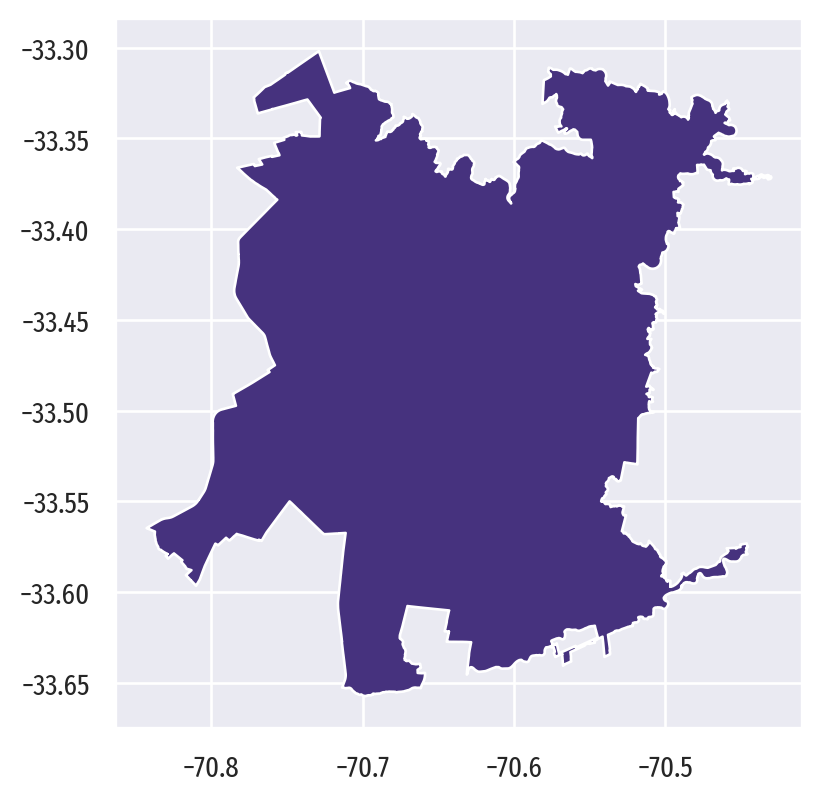

In [12]:
# Leer el archivo GeoJSON
urban_stgo = gpd.read_file('censo2017/urban_stgo_border/urban_stgo_border.shp')

# Establecer el sistema de referencia de coordenadas inicial
urban_stgo = urban_stgo.set_crs('EPSG:4326')

# Cambiar el sistema de referencia de coordenadas a EPSG:4326 (hay otros)
urban_stgo = urban_stgo.to_crs('EPSG:4326')

# Hacer el gráfico de las áreas urbanas de Santiago
urban_stgo.plot()

Esa área urbana define el borde del área que nos interesa estudiar, pero necesitamos cargar los bordes de cada distrito censal. Lo hacemos como sigue:

In [13]:
# Leer el archivo GeoJSON
distritos = gpd.read_file('./censo2017/R13/')
distritos

REGION PROVINCIA COMUNA  COD_DISTRI                        DESC_REGIO  \
0       13       131  13114         4.0  REGIÓN METROPOLITANA DE SANTIAGO   
1       13       131  13114        15.0  REGIÓN METROPOLITANA DE SANTIAGO   
2       13       131  13114        16.0  REGIÓN METROPOLITANA DE SANTIAGO   
3       13       131  13114         2.0  REGIÓN METROPOLITANA DE SANTIAGO   
4       13       131  13114         3.0  REGIÓN METROPOLITANA DE SANTIAGO   
..     ...       ...    ...         ...                               ...   
446     13       135  13501         1.0  REGIÓN METROPOLITANA DE SANTIAGO   
447     13       135  13501         7.0  REGIÓN METROPOLITANA DE SANTIAGO   
448     13       135  13501        13.0  REGIÓN METROPOLITANA DE SANTIAGO   
449     13       135  13501         8.0  REGIÓN METROPOLITANA DE SANTIAGO   
450     13       131  13118         5.0  REGIÓN METROPOLITANA DE SANTIAGO   

    DESC_PROVI  DESC_COMUN                      DESC_DISTR  \
0     SANTIAGO  LAS CONDES                      LAS CONDES   
1     SANTIAGO  LAS CONDES         SAN CARLOS DE APOQUINDO   
2     SANTIAGO  LAS CONDES                     CERRO CALÁN   
3     SANTIAGO  LAS CONDES               ESTADIO PALESTINO   
4     SANTIAGO  LAS CONDES                   HOSPITAL FACH   
..         ...         ...                             ...   
446  MELIPILLA   MELIPILLA              MELIPILLA PONIENTE   
447  MELIPILLA   MELIPILLA                        CULIPRÁN   
448  MELIPILLA   MELIPILLA                PUANGUE PONIENTE   
449  MELIPILLA   MELIPILLA                         HUECHÚN   
450   SANTIAGO       MACUL  VILLA SANTA CAROLINA VILLA SAN   

                                              geometry  
0    POLYGON ((-70.47951 -33.36433, -70.47940 -33.3...  
1    POLYGON ((-70.50074 -33.37846, -70.50045 -33.3...  
2    POLYGON ((-70.50789 -33.38245, -70.50774 -33.3...  
3    POLYGON ((-70.53606 -33.38529, -70.53652 -33.3...  
4    POLYGON ((-70.54504 -33.39658, -70.54575 -33.3...  
..                                                 ...  
446  POLYGON ((-71.22747 -33.67002, -71.22402 -33.6...  
447  POLYGON ((-71.19488 -33.78527, -71.19403 -33.7...  
448  POLYGON ((-71.31653 -33.58829, -71.31629 -33.5...  
449  POLYGON ((-71.32236 -33.66578, -71.32134 -33.6...  
450  POLYGON ((-70.59876 -33.47380, -70.59881 -33.4...  

[451 rows x 9 columns]

In [14]:
# Convertir las columnas a enteros
distritos['REGION'] = distritos['REGION'].astype(int)
distritos['PROVINCIA'] = distritos['PROVINCIA'].astype(int)
distritos['COMUNA'] = distritos['COMUNA'].astype(int)
distritos['COD_DISTRI'] = distritos['COD_DISTRI'].astype(int)

# Obtener la longitud del GeoDataFrame
distritos_len= len(distritos)
print(distritos_len)

451


En la RM hay 451 áreas censales. Por cierto, los valores de región, provincia, comuna y distrito no vienen como números enteros, por eso debimos realizar esas operaciones `astype`.

Grafiquemos los distritos:

<Axes: >

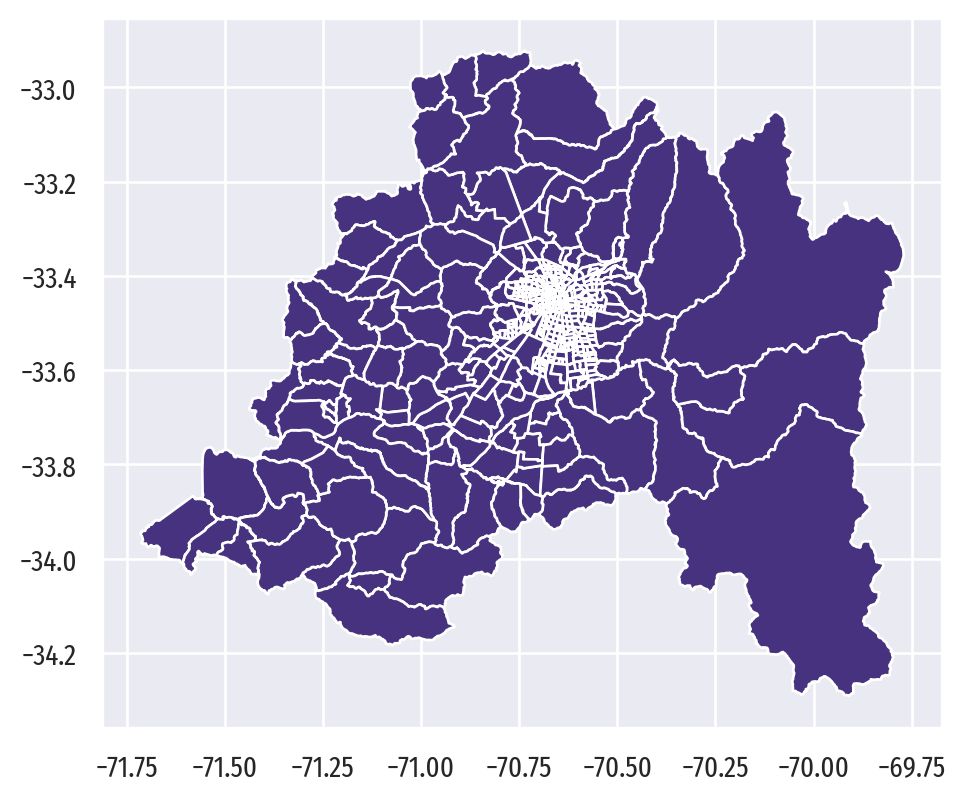

In [15]:
distritos.plot()

Como está toda la región, necesitamos quedarnos con los distritos que se intersectan con el área urbana. Lo hacemos así:

In [16]:
urban_stgo

FID                                           geometry
0    0  POLYGON ((-70.76164 -33.56445, -70.76198 -33.5...

CRS de distritos transformado: EPSG:4326
CRS de urban_stgo: EPSG:4326


<Axes: >

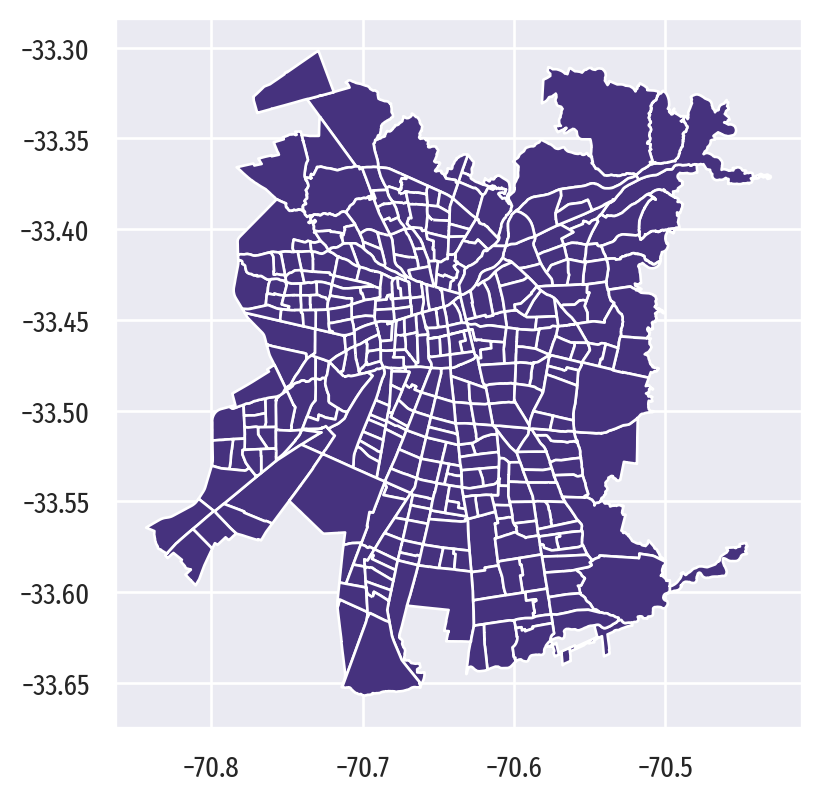

In [17]:
# Transformar el CRS de distritos a EPSG:4326
distritos = distritos.to_crs('EPSG:4326')

# Verificar que ambos GeoDataFrames tienen el mismo CRS
print("CRS de distritos transformado:", distritos.crs)
print("CRS de urban_stgo:", urban_stgo.crs)

# Realizar la intersección
urban_districts = gpd.overlay(distritos, urban_stgo, how='intersection')

# Hacer el gráfico de la intersección
urban_districts.plot()


In [18]:
urban_districts.head()

REGION  PROVINCIA  COMUNA  COD_DISTRI                        DESC_REGIO  \
0      13        131   13114           4  REGIÓN METROPOLITANA DE SANTIAGO   
1      13        131   13114          15  REGIÓN METROPOLITANA DE SANTIAGO   
2      13        131   13114          16  REGIÓN METROPOLITANA DE SANTIAGO   
3      13        131   13114           2  REGIÓN METROPOLITANA DE SANTIAGO   
4      13        131   13114           3  REGIÓN METROPOLITANA DE SANTIAGO   

  DESC_PROVI  DESC_COMUN               DESC_DISTR  FID  \
0   SANTIAGO  LAS CONDES               LAS CONDES    0   
1   SANTIAGO  LAS CONDES  SAN CARLOS DE APOQUINDO    0   
2   SANTIAGO  LAS CONDES              CERRO CALÁN    0   
3   SANTIAGO  LAS CONDES        ESTADIO PALESTINO    0   
4   SANTIAGO  LAS CONDES            HOSPITAL FACH    0   

                                            geometry  
0  POLYGON ((-70.47940 -33.36434, -70.47931 -33.3...  
1  POLYGON ((-70.50045 -33.37855, -70.50037 -33.3...  
2  POLYGON ((-70.50774 -33.38250, -70.50764 -33.3...  
3  POLYGON ((-70.53652 -33.38549, -70.53657 -33.3...  
4  POLYGON ((-70.54575 -33.39769, -70.54613 -33.3...

Podemos guardar este mapa para utilizarlo más adelante.

In [19]:
!mkdir -p output

In [20]:
# Utilizamos el método 'to_file' del GeoDataFrame 'urban_districts' para guardar los datos geográficos.
# Este método permite exportar el GeoDataFrame a un archivo en un formato específico, en este caso, un shapefile.
urban_districts.to_file('output/stgo_urban_districts.shp', driver='ESRI Shapefile')

# El primer argumento 'output/stgo_urban_districts.shp' indica la ruta de archivo y el nombre bajo el cual se guardará el archivo.


Ahora mezclémoslos con los datos.

In [21]:
urban_data = urban_districts.merge(dc_values, how='inner')

In [22]:
urban_data

REGION  PROVINCIA  COMUNA  COD_DISTRI                        DESC_REGIO  \
0        13        131   13114           4  REGIÓN METROPOLITANA DE SANTIAGO   
1        13        131   13114          15  REGIÓN METROPOLITANA DE SANTIAGO   
2        13        131   13114          16  REGIÓN METROPOLITANA DE SANTIAGO   
3        13        131   13114           2  REGIÓN METROPOLITANA DE SANTIAGO   
4        13        131   13114           3  REGIÓN METROPOLITANA DE SANTIAGO   
..      ...        ...     ...         ...                               ...   
342      13        136   13604           1  REGIÓN METROPOLITANA DE SANTIAGO   
343      13        136   13604           3  REGIÓN METROPOLITANA DE SANTIAGO   
344      13        136   13604           4  REGIÓN METROPOLITANA DE SANTIAGO   
345      13        133   13302           4  REGIÓN METROPOLITANA DE SANTIAGO   
346      13        131   13118           5  REGIÓN METROPOLITANA DE SANTIAGO   

    DESC_PROVI     DESC_COMUN                      DESC_DISTR  FID  \
0     SANTIAGO     LAS CONDES                      LAS CONDES    0   
1     SANTIAGO     LAS CONDES         SAN CARLOS DE APOQUINDO    0   
2     SANTIAGO     LAS CONDES                     CERRO CALÁN    0   
3     SANTIAGO     LAS CONDES               ESTADIO PALESTINO    0   
4     SANTIAGO     LAS CONDES                   HOSPITAL FACH    0   
..         ...            ...                             ...  ...   
342  TALAGANTE  PADRE HURTADO              CASA DE EJERCICIOS    0   
343  TALAGANTE  PADRE HURTADO                   PADRE HURTADO    0   
344  TALAGANTE  PADRE HURTADO                 VILLA LOS SILOS    0   
345  CHACABUCO          LAMPA                       LA VILANA    0   
346   SANTIAGO          MACUL  VILLA SANTA CAROLINA VILLA SAN    0   

                                              geometry  HOMBRES  MUJERES  \
0    POLYGON ((-70.47940 -33.36434, -70.47931 -33.3...     7140     8978   
1    POLYGON ((-70.50045 -33.37855, -70.50037 -33.3...     8120     9040   
2    POLYGON ((-70.50774 -33.38250, -70.50764 -33.3...     6705     7886   
3    POLYGON ((-70.53652 -33.38549, -70.53657 -33.3...     6576     7747   
4    POLYGON ((-70.54575 -33.39769, -70.54613 -33.3...     9076    10521   
..                                                 ...      ...      ...   
342  POLYGON ((-70.80540 -33.55063, -70.80288 -33.5...     3556     3697   
343  POLYGON ((-70.79794 -33.55565, -70.79794 -33.5...     9742     9924   
344  POLYGON ((-70.82936 -33.57881, -70.82933 -33.5...    14139    14479   
345  POLYGON ((-70.72696 -33.32623, -70.72699 -33.3...    32895    32577   
346  POLYGON ((-70.59881 -33.47482, -70.59882 -33.4...     5415     6147   

     EDAD_0A5  EDAD_6A14  EDAD_15A64  EDAD_65YMAS  INMIGRANTES  
0        1021       1562       10831         2466         1487  
1         936       2489       12392          884         1632  
2         616       1412        9940         2337         1180  
3         949        999        9862         2195         1632  
4        1033       1236       13872         2966         2716  
..        ...        ...         ...          ...          ...  
342       818        718        4888          309          158  
343      1540       2193       13318         2205          508  
344      2272       3598       19935         2003          593  
345      7632       8898       44553         1758         2757  
346       735        897        7854         1716          613  

[347 rows x 17 columns]

Calculemos las variables que necesitamos para responder nuestras preguntas iniciales.

In [23]:
urban_data['POPULATION'] = urban_data['HOMBRES'] + urban_data['MUJERES']
urban_data.POPULATION.describe()

count      347.000000
mean     17814.080692
std      12749.284236
min        440.000000
25%      11300.500000
50%      14693.000000
75%      20430.500000
max      98090.000000
Name: POPULATION, dtype: float64

In [24]:
# Calcular el ratio de diferencia porcentual entre mujeres y hombres respecto a la población total.
urban_data['RATIO'] = ((urban_data['MUJERES'] - urban_data['HOMBRES']) / urban_data['POPULATION'] * 100)

# Obtener estadísticas descriptivas de la columna 'RATIO' para entender su distribución, centralidad y dispersión.
urban_data.RATIO.describe()


count    347.000000
mean       2.740746
std        5.566922
min      -83.073011
25%        1.295353
50%        2.726106
75%        4.467027
max       11.570881
Name: RATIO, dtype: float64

**Interpretación de la variable RATIO:**

- Un RATIO positivo indica un mayor porcentaje de mujeres en comparación con hombres en la población.
- Un RATIO negativo sugiere un mayor porcentaje de hombres en comparación con mujeres.
- Un RATIO cercano a cero implica una distribución casi equitativa entre mujeres y hombres en esa área.

In [25]:
urban_data['RETIRED_%'] = urban_data['EDAD_65YMAS'] / urban_data['POPULATION'] * 100
urban_data['RETIRED_%'].describe()

count    347.000000
mean      11.908847
std        4.004277
min        0.000000
25%        8.927512
50%       12.466019
75%       14.720273
max       20.260310
Name: RETIRED_%, dtype: float64

In [26]:
urban_data

REGION  PROVINCIA  COMUNA  COD_DISTRI                        DESC_REGIO  \
0        13        131   13114           4  REGIÓN METROPOLITANA DE SANTIAGO   
1        13        131   13114          15  REGIÓN METROPOLITANA DE SANTIAGO   
2        13        131   13114          16  REGIÓN METROPOLITANA DE SANTIAGO   
3        13        131   13114           2  REGIÓN METROPOLITANA DE SANTIAGO   
4        13        131   13114           3  REGIÓN METROPOLITANA DE SANTIAGO   
..      ...        ...     ...         ...                               ...   
342      13        136   13604           1  REGIÓN METROPOLITANA DE SANTIAGO   
343      13        136   13604           3  REGIÓN METROPOLITANA DE SANTIAGO   
344      13        136   13604           4  REGIÓN METROPOLITANA DE SANTIAGO   
345      13        133   13302           4  REGIÓN METROPOLITANA DE SANTIAGO   
346      13        131   13118           5  REGIÓN METROPOLITANA DE SANTIAGO   

    DESC_PROVI     DESC_COMUN                      DESC_DISTR  FID  \
0     SANTIAGO     LAS CONDES                      LAS CONDES    0   
1     SANTIAGO     LAS CONDES         SAN CARLOS DE APOQUINDO    0   
2     SANTIAGO     LAS CONDES                     CERRO CALÁN    0   
3     SANTIAGO     LAS CONDES               ESTADIO PALESTINO    0   
4     SANTIAGO     LAS CONDES                   HOSPITAL FACH    0   
..         ...            ...                             ...  ...   
342  TALAGANTE  PADRE HURTADO              CASA DE EJERCICIOS    0   
343  TALAGANTE  PADRE HURTADO                   PADRE HURTADO    0   
344  TALAGANTE  PADRE HURTADO                 VILLA LOS SILOS    0   
345  CHACABUCO          LAMPA                       LA VILANA    0   
346   SANTIAGO          MACUL  VILLA SANTA CAROLINA VILLA SAN    0   

                                              geometry  HOMBRES  MUJERES  \
0    POLYGON ((-70.47940 -33.36434, -70.47931 -33.3...     7140     8978   
1    POLYGON ((-70.50045 -33.37855, -70.50037 -33.3...     8120     9040   
2    POLYGON ((-70.50774 -33.38250, -70.50764 -33.3...     6705     7886   
3    POLYGON ((-70.53652 -33.38549, -70.53657 -33.3...     6576     7747   
4    POLYGON ((-70.54575 -33.39769, -70.54613 -33.3...     9076    10521   
..                                                 ...      ...      ...   
342  POLYGON ((-70.80540 -33.55063, -70.80288 -33.5...     3556     3697   
343  POLYGON ((-70.79794 -33.55565, -70.79794 -33.5...     9742     9924   
344  POLYGON ((-70.82936 -33.57881, -70.82933 -33.5...    14139    14479   
345  POLYGON ((-70.72696 -33.32623, -70.72699 -33.3...    32895    32577   
346  POLYGON ((-70.59881 -33.47482, -70.59882 -33.4...     5415     6147   

     EDAD_0A5  EDAD_6A14  EDAD_15A64  EDAD_65YMAS  INMIGRANTES  POPULATION  \
0        1021       1562       10831         2466         1487       16118   
1         936       2489       12392          884         1632       17160   
2         616       1412        9940         2337         1180       14591   
3         949        999        9862         2195         1632       14323   
4        1033       1236       13872         2966         2716       19597   
..        ...        ...         ...          ...          ...         ...   
342       818        718        4888          309          158        7253   
343      1540       2193       13318         2205          508       19666   
344      2272       3598       19935         2003          593       28618   
345      7632       8898       44553         1758         2757       65472   
346       735        897        7854         1716          613       11562   

         RATIO  RETIRED_%  
0    11.403400  15.299665  
1     5.361305   5.151515  
2     8.094031  16.016723  
3     8.175662  15.325002  
4     7.373578  15.134970  
..         ...        ...  
342   1.944023   4.260306  
343   0.925455  11.212244  
344   1.188063   6.999091  
345  -0.485704   2.685117  
346   6.331085  14.841723  

[347 rows x 20 c

## ¡Mapas!

Ahora que calculamos las variables necesarias, grafiquemos los mapas :D

# Retirados

In [27]:
# Calcular los límites de los intervalos para 5 bins
bins = np.linspace(urban_data['RETIRED_%'].min(), urban_data['RETIRED_%'].max(), 6)  # 5 bins, 6 límites

# Crear etiquetas como rangos
labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins)-1)]

# Discretizar la columna 'INMIGRANTES' usando los bins y las etiquetas
urban_data['RETIRED_CAT'] = pd.cut(urban_data['RETIRED_%'], bins=bins, labels=labels, include_lowest=True)

In [28]:
urban_data

REGION  PROVINCIA  COMUNA  COD_DISTRI                        DESC_REGIO  \
0        13        131   13114           4  REGIÓN METROPOLITANA DE SANTIAGO   
1        13        131   13114          15  REGIÓN METROPOLITANA DE SANTIAGO   
2        13        131   13114          16  REGIÓN METROPOLITANA DE SANTIAGO   
3        13        131   13114           2  REGIÓN METROPOLITANA DE SANTIAGO   
4        13        131   13114           3  REGIÓN METROPOLITANA DE SANTIAGO   
..      ...        ...     ...         ...                               ...   
342      13        136   13604           1  REGIÓN METROPOLITANA DE SANTIAGO   
343      13        136   13604           3  REGIÓN METROPOLITANA DE SANTIAGO   
344      13        136   13604           4  REGIÓN METROPOLITANA DE SANTIAGO   
345      13        133   13302           4  REGIÓN METROPOLITANA DE SANTIAGO   
346      13        131   13118           5  REGIÓN METROPOLITANA DE SANTIAGO   

    DESC_PROVI     DESC_COMUN                      DESC_DISTR  FID  \
0     SANTIAGO     LAS CONDES                      LAS CONDES    0   
1     SANTIAGO     LAS CONDES         SAN CARLOS DE APOQUINDO    0   
2     SANTIAGO     LAS CONDES                     CERRO CALÁN    0   
3     SANTIAGO     LAS CONDES               ESTADIO PALESTINO    0   
4     SANTIAGO     LAS CONDES                   HOSPITAL FACH    0   
..         ...            ...                             ...  ...   
342  TALAGANTE  PADRE HURTADO              CASA DE EJERCICIOS    0   
343  TALAGANTE  PADRE HURTADO                   PADRE HURTADO    0   
344  TALAGANTE  PADRE HURTADO                 VILLA LOS SILOS    0   
345  CHACABUCO          LAMPA                       LA VILANA    0   
346   SANTIAGO          MACUL  VILLA SANTA CAROLINA VILLA SAN    0   

                                              geometry  HOMBRES  MUJERES  \
0    POLYGON ((-70.47940 -33.36434, -70.47931 -33.3...     7140     8978   
1    POLYGON ((-70.50045 -33.37855, -70.50037 -33.3...     8120     9040   
2    POLYGON ((-70.50774 -33.38250, -70.50764 -33.3...     6705     7886   
3    POLYGON ((-70.53652 -33.38549, -70.53657 -33.3...     6576     7747   
4    POLYGON ((-70.54575 -33.39769, -70.54613 -33.3...     9076    10521   
..                                                 ...      ...      ...   
342  POLYGON ((-70.80540 -33.55063, -70.80288 -33.5...     3556     3697   
343  POLYGON ((-70.79794 -33.55565, -70.79794 -33.5...     9742     9924   
344  POLYGON ((-70.82936 -33.57881, -70.82933 -33.5...    14139    14479   
345  POLYGON ((-70.72696 -33.32623, -70.72699 -33.3...    32895    32577   
346  POLYGON ((-70.59881 -33.47482, -70.59882 -33.4...     5415     6147   

     EDAD_0A5  EDAD_6A14  EDAD_15A64  EDAD_65YMAS  INMIGRANTES  POPULATION  \
0        1021       1562       10831         2466         1487       16118   
1         936       2489       12392          884         1632       17160   
2         616       1412        9940         2337         1180       14591   
3         949        999        9862         2195         1632       14323   
4        1033       1236       13872         2966         2716       19597   
..        ...        ...         ...          ...          ...         ...   
342       818        718        4888          309          158        7253   
343      1540       2193       13318         2205          508       19666   
344      2272       3598       19935         2003          593       28618   
345      7632       8898       44553         1758         2757       65472   
346       735        897        7854         1716          613       11562   

         RATIO  RETIRED_% RETIRED_CAT  
0    11.403400  15.299665       12-16  
1     5.361305   5.151515         4-8  
2     8.094031  16.016723       12-16  
3     8.175662  15.325002       12-16  
4     7.373578  15.134970       12-16  
..         ...        ...         ...  
342   1.944023   4.260306         4-8  
343   0.925455  11.212244        

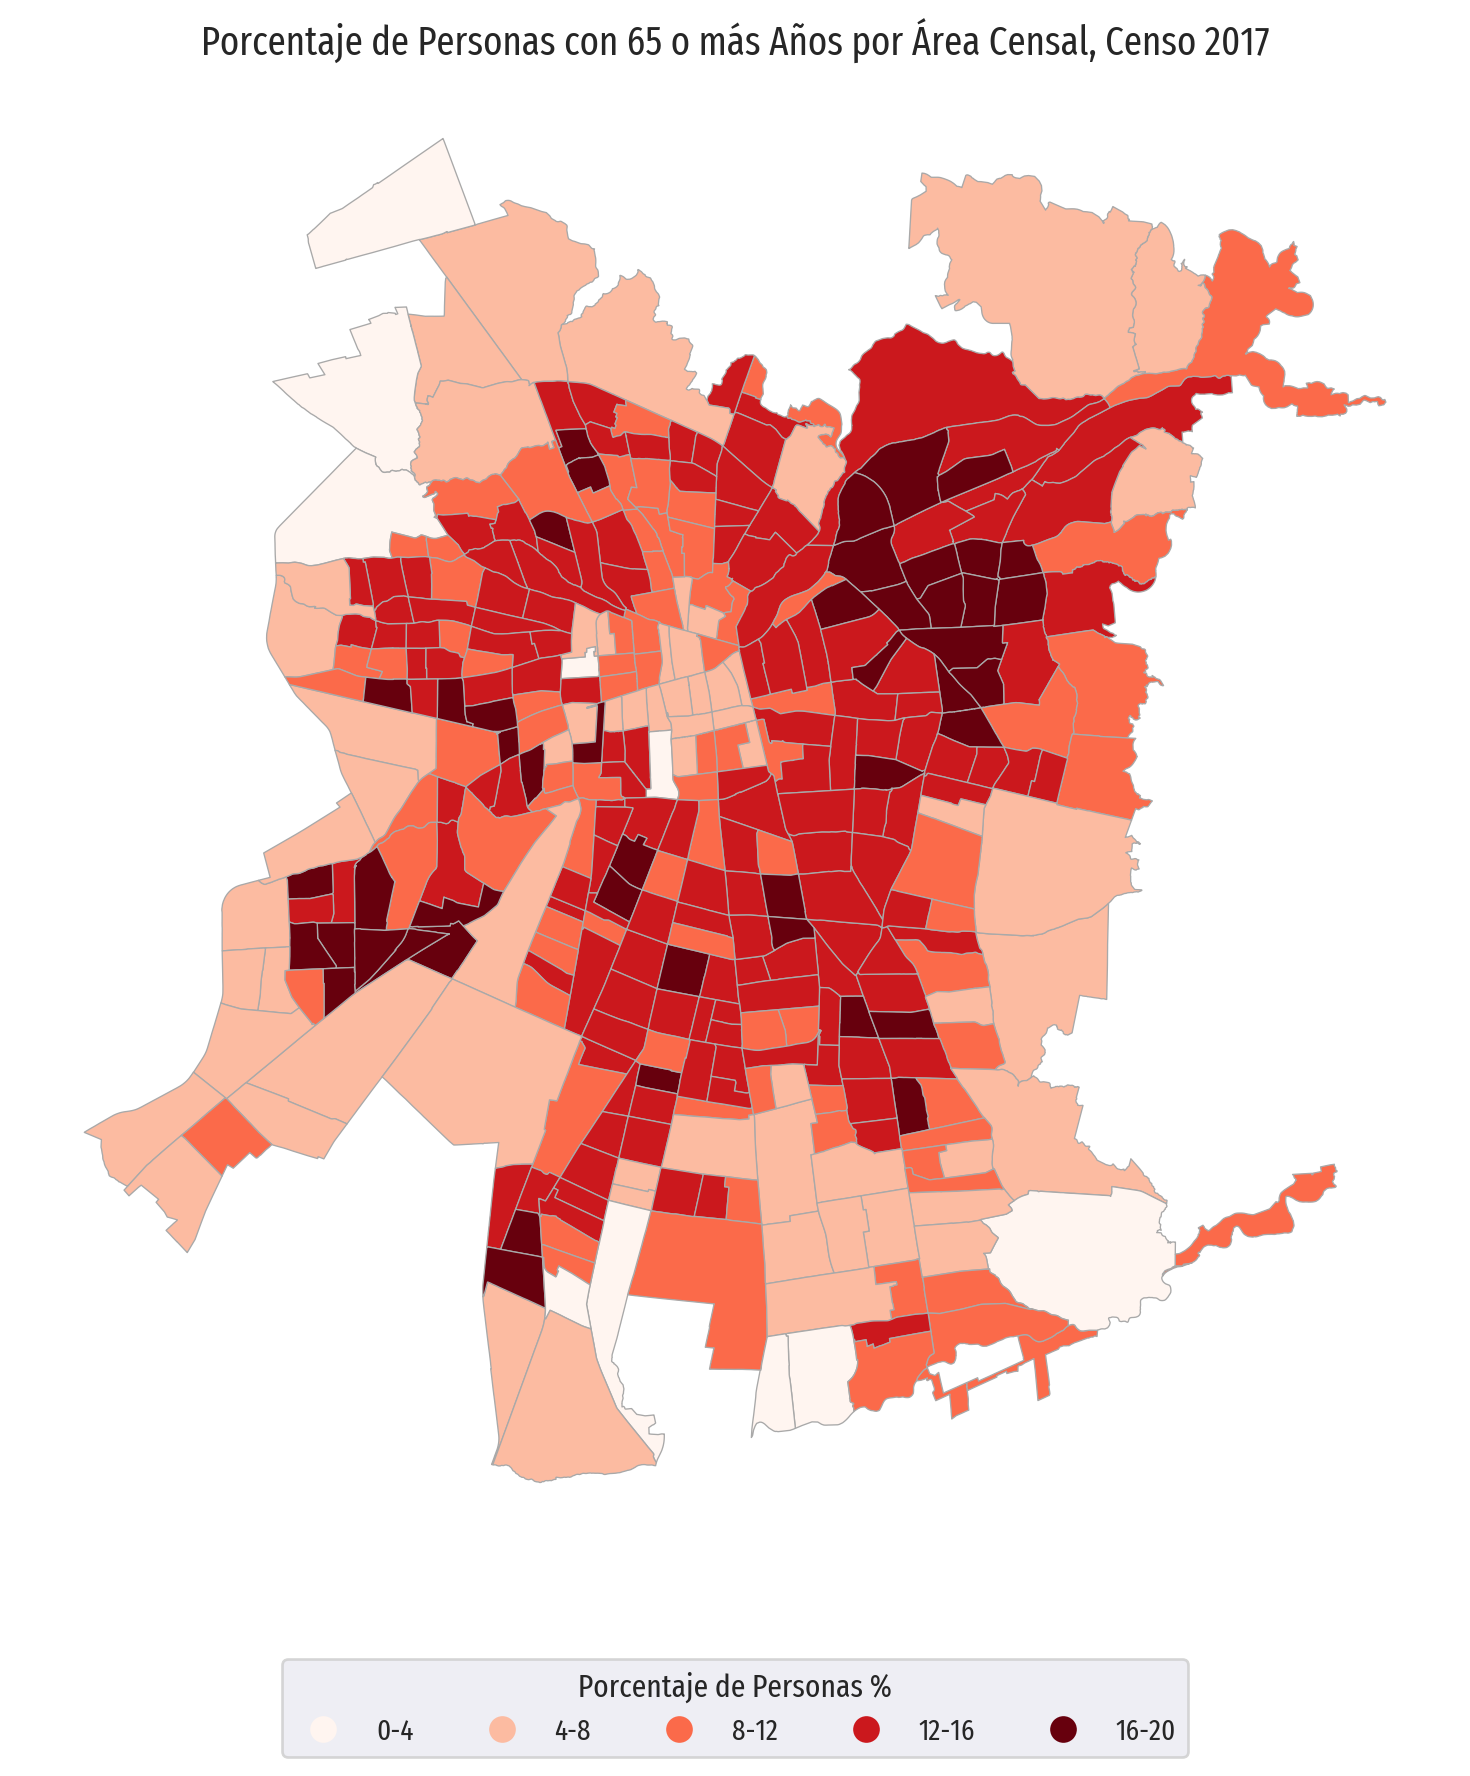

In [29]:
# Crear una paleta de colores con 5 tonos de azul
cmap = plt.get_cmap('Reds', 5)  # 'Blues' para usar tonos de azul

# Dibujar el gráfico de cloropletas
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
urban_data.plot(column='RETIRED_CAT', ax=ax, legend=True,
                cmap=cmap, edgecolor='darkgrey', linewidth=0.5,
                legend_kwds={'title': "Porcentaje de Personas Retiradas %", 'loc': 'lower center', 'bbox_to_anchor': (0.5, -0.15), 'ncol':5})

# Agregar título y ajustes adicionales
ax.set_title("Porcentaje de Personas con 65 o más Años por Área Censal, Censo 2017", fontsize=15)
ax.set_axis_off()  # Opcional: elimina los ejes para una visualización más limpia

plt.show()
fig.savefig('censo2017_figuras/retired.png', dpi=150, bbox_inches='tight')

**Interpretación**: El gráfico muestra la distribución porcentual de personas mayores de 65 años en diferentes zonas de la Región Metropolitana (RM) de Chile. Los colores más claros indican una menor proporción de personas mayores de 65 años (0-4%), mientras que los colores más oscuros indican una mayor proporción de personas mayores de 65 años (16-20%). Las áreas con colores más oscuros, que representan una mayor proporción de personas mayores de 65 años, se concentran en la parte norte y centro-este de la región. Las zonas con colores más claros, que indican una menor proporción de personas mayores de 65 años, se encuentran principalmente en el extremo oeste y algunas áreas del sur. Las áreas con una mayor proporción de personas mayores de 65 años podrían estar correlacionadas con factores socioeconómicos como el nivel de ingresos y el acceso a servicios de salud. En resumen, este mapa proporciona una visión general de la distribución demográfica de las personas mayores en la Región Metropolitana, destacando las áreas con mayor concentración de personas mayores de 65 años.

# Relación Porcentual entre Mujeres (+%) y Hombres (-%)

In [30]:
# Calcular los límites de los intervalos para 5 bins
# Definir los bins manualmente
#bins = [-np.inf, -80,-60,-40, -20, 0, 20]
#labels = ["-80", "-80 - -60", "-60 - -40", "-40- -20", "-20-0", "0-20"]

# Calcular los límites de los intervalos para 5 bins
bins = np.linspace(urban_data['RATIO'].min(), urban_data['RATIO'].max(), 6)  # 5 bins, 6 límites

# Inicializar una lista vacía para almacenar las etiquetas
labels = []

# Usar un bucle for para crear etiquetas para cada bin
for i in range(len(bins) - 1):
    start = int(bins[i])  # Inicio del intervalo
    end = int(bins[i+1])  # Fin del intervalo
    label = f"{start}-{end}"  # Crear la etiqueta como un rango
    labels.append(label)  # Añadir la etiqueta a la lista

# Discretizar la columna 'INMIGRANTES' usando los bins y las etiquetas
urban_data['RATIO_CAT'] = pd.cut(urban_data['RATIO'], bins=bins, labels=labels, include_lowest=True)

In [31]:
urban_data

REGION  PROVINCIA  COMUNA  COD_DISTRI                        DESC_REGIO  \
0        13        131   13114           4  REGIÓN METROPOLITANA DE SANTIAGO   
1        13        131   13114          15  REGIÓN METROPOLITANA DE SANTIAGO   
2        13        131   13114          16  REGIÓN METROPOLITANA DE SANTIAGO   
3        13        131   13114           2  REGIÓN METROPOLITANA DE SANTIAGO   
4        13        131   13114           3  REGIÓN METROPOLITANA DE SANTIAGO   
..      ...        ...     ...         ...                               ...   
342      13        136   13604           1  REGIÓN METROPOLITANA DE SANTIAGO   
343      13        136   13604           3  REGIÓN METROPOLITANA DE SANTIAGO   
344      13        136   13604           4  REGIÓN METROPOLITANA DE SANTIAGO   
345      13        133   13302           4  REGIÓN METROPOLITANA DE SANTIAGO   
346      13        131   13118           5  REGIÓN METROPOLITANA DE SANTIAGO   

    DESC_PROVI     DESC_COMUN                      DESC_DISTR  FID  \
0     SANTIAGO     LAS CONDES                      LAS CONDES    0   
1     SANTIAGO     LAS CONDES         SAN CARLOS DE APOQUINDO    0   
2     SANTIAGO     LAS CONDES                     CERRO CALÁN    0   
3     SANTIAGO     LAS CONDES               ESTADIO PALESTINO    0   
4     SANTIAGO     LAS CONDES                   HOSPITAL FACH    0   
..         ...            ...                             ...  ...   
342  TALAGANTE  PADRE HURTADO              CASA DE EJERCICIOS    0   
343  TALAGANTE  PADRE HURTADO                   PADRE HURTADO    0   
344  TALAGANTE  PADRE HURTADO                 VILLA LOS SILOS    0   
345  CHACABUCO          LAMPA                       LA VILANA    0   
346   SANTIAGO          MACUL  VILLA SANTA CAROLINA VILLA SAN    0   

                                              geometry  HOMBRES  MUJERES  \
0    POLYGON ((-70.47940 -33.36434, -70.47931 -33.3...     7140     8978   
1    POLYGON ((-70.50045 -33.37855, -70.50037 -33.3...     8120     9040   
2    POLYGON ((-70.50774 -33.38250, -70.50764 -33.3...     6705     7886   
3    POLYGON ((-70.53652 -33.38549, -70.53657 -33.3...     6576     7747   
4    POLYGON ((-70.54575 -33.39769, -70.54613 -33.3...     9076    10521   
..                                                 ...      ...      ...   
342  POLYGON ((-70.80540 -33.55063, -70.80288 -33.5...     3556     3697   
343  POLYGON ((-70.79794 -33.55565, -70.79794 -33.5...     9742     9924   
344  POLYGON ((-70.82936 -33.57881, -70.82933 -33.5...    14139    14479   
345  POLYGON ((-70.72696 -33.32623, -70.72699 -33.3...    32895    32577   
346  POLYGON ((-70.59881 -33.47482, -70.59882 -33.4...     5415     6147   

     EDAD_0A5  EDAD_6A14  EDAD_15A64  EDAD_65YMAS  INMIGRANTES  POPULATION  \
0        1021       1562       10831         2466         1487       16118   
1         936       2489       12392          884         1632       17160   
2         616       1412        9940         2337         1180       14591   
3         949        999        9862         2195         1632       14323   
4        1033       1236       13872         2966         2716       19597   
..        ...        ...         ...          ...          ...         ...   
342       818        718        4888          309          158        7253   
343      1540       2193       13318         2205          508       19666   
344      2272       3598       19935         2003          593       28618   
345      7632       8898       44553         1758         2757       65472   
346       735        897        7854         1716          613       11562   

         RATIO  RETIRED_% RETIRED_CAT RATIO_CAT  
0    11.403400  15.299665       12-16     -7-11  
1     5.361305   5.151515         4-8     -7-11  
2     8.094031  16.016723       12-16     -7-11  
3     8.175662  15.325002       12-16     -7-11  
4     7.373578  15.134970       12-16     -7-11  
..         ...        ...         ...       ...  
342

In [32]:
urban_data['RATIO'].max()

11.57088122605364

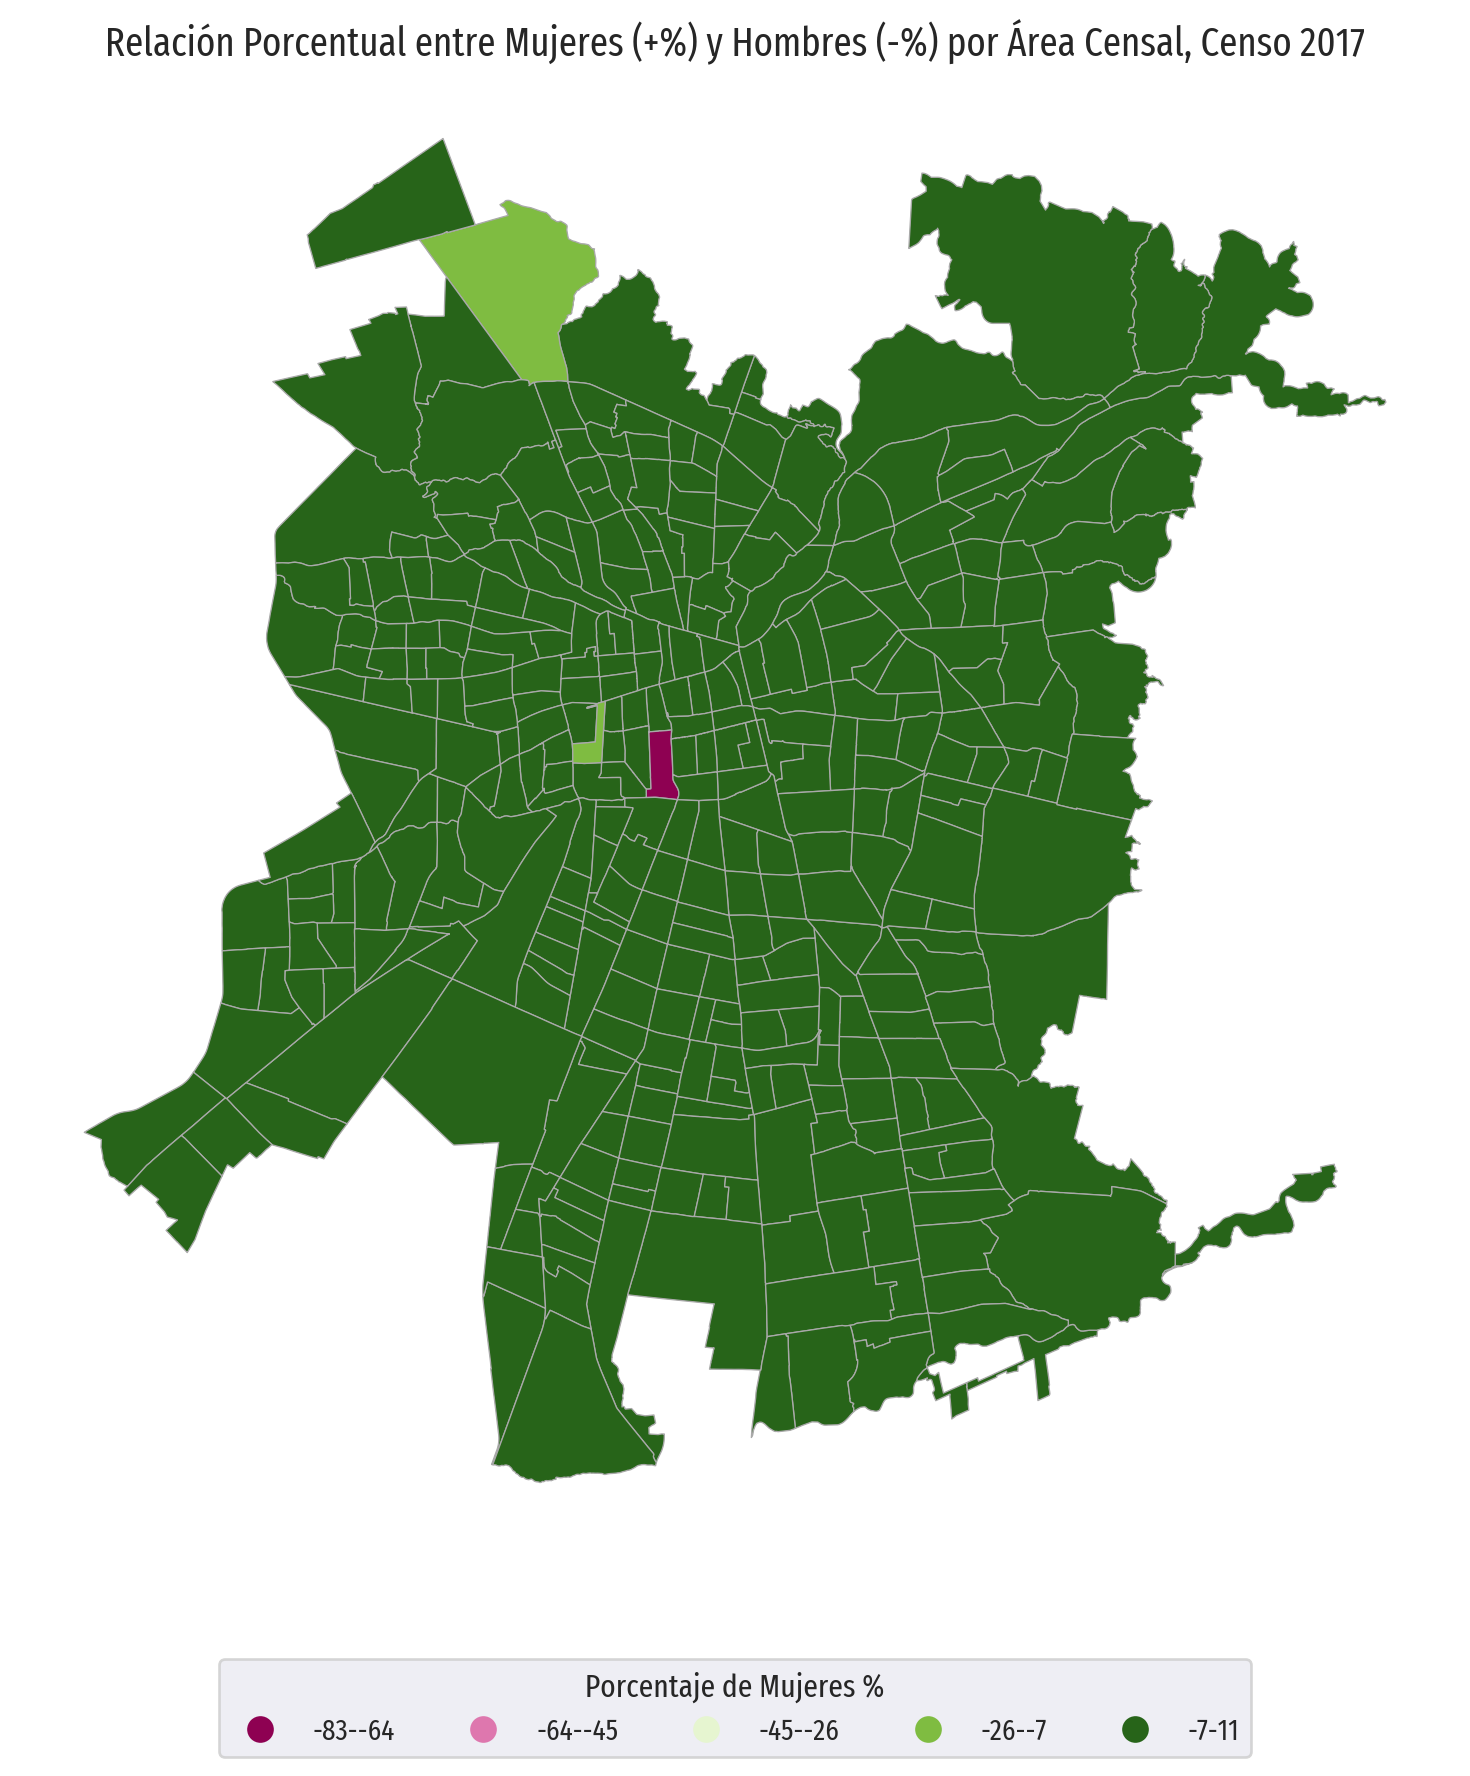

In [33]:
# Crear una paleta de colores con una paleta divergente, ajustando el centro al 0
cmap = plt.get_cmap('PiYG', 6)

# Dibujar el gráfico de cloropletas
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
urban_data.plot(column='RATIO_CAT', ax=ax, legend=True,
                cmap=cmap, edgecolor='darkgrey', linewidth=0.5,
                legend_kwds={'title': "Porcentaje de Mujeres %", 'loc': 'lower center', 'bbox_to_anchor': (0.5, -0.15), 'ncol':6})

# Agregar título y ajustes adicionales
ax.set_title("Relación Porcentual entre Mujeres (+%) y Hombres (-%) por Área Censal, Censo 2017", fontsize=15)
ax.set_axis_off()  # Opcional: elimina los ejes para una visualización más limpia

plt.show()
fig.savefig('censo2017_figuras/mujeres_vs_hombres.png', dpi=150, bbox_inches='tight')

In [34]:
bins

array([-83.07301126, -64.14423276, -45.21545427, -26.28667577,
        -7.35789727,  11.57088123])

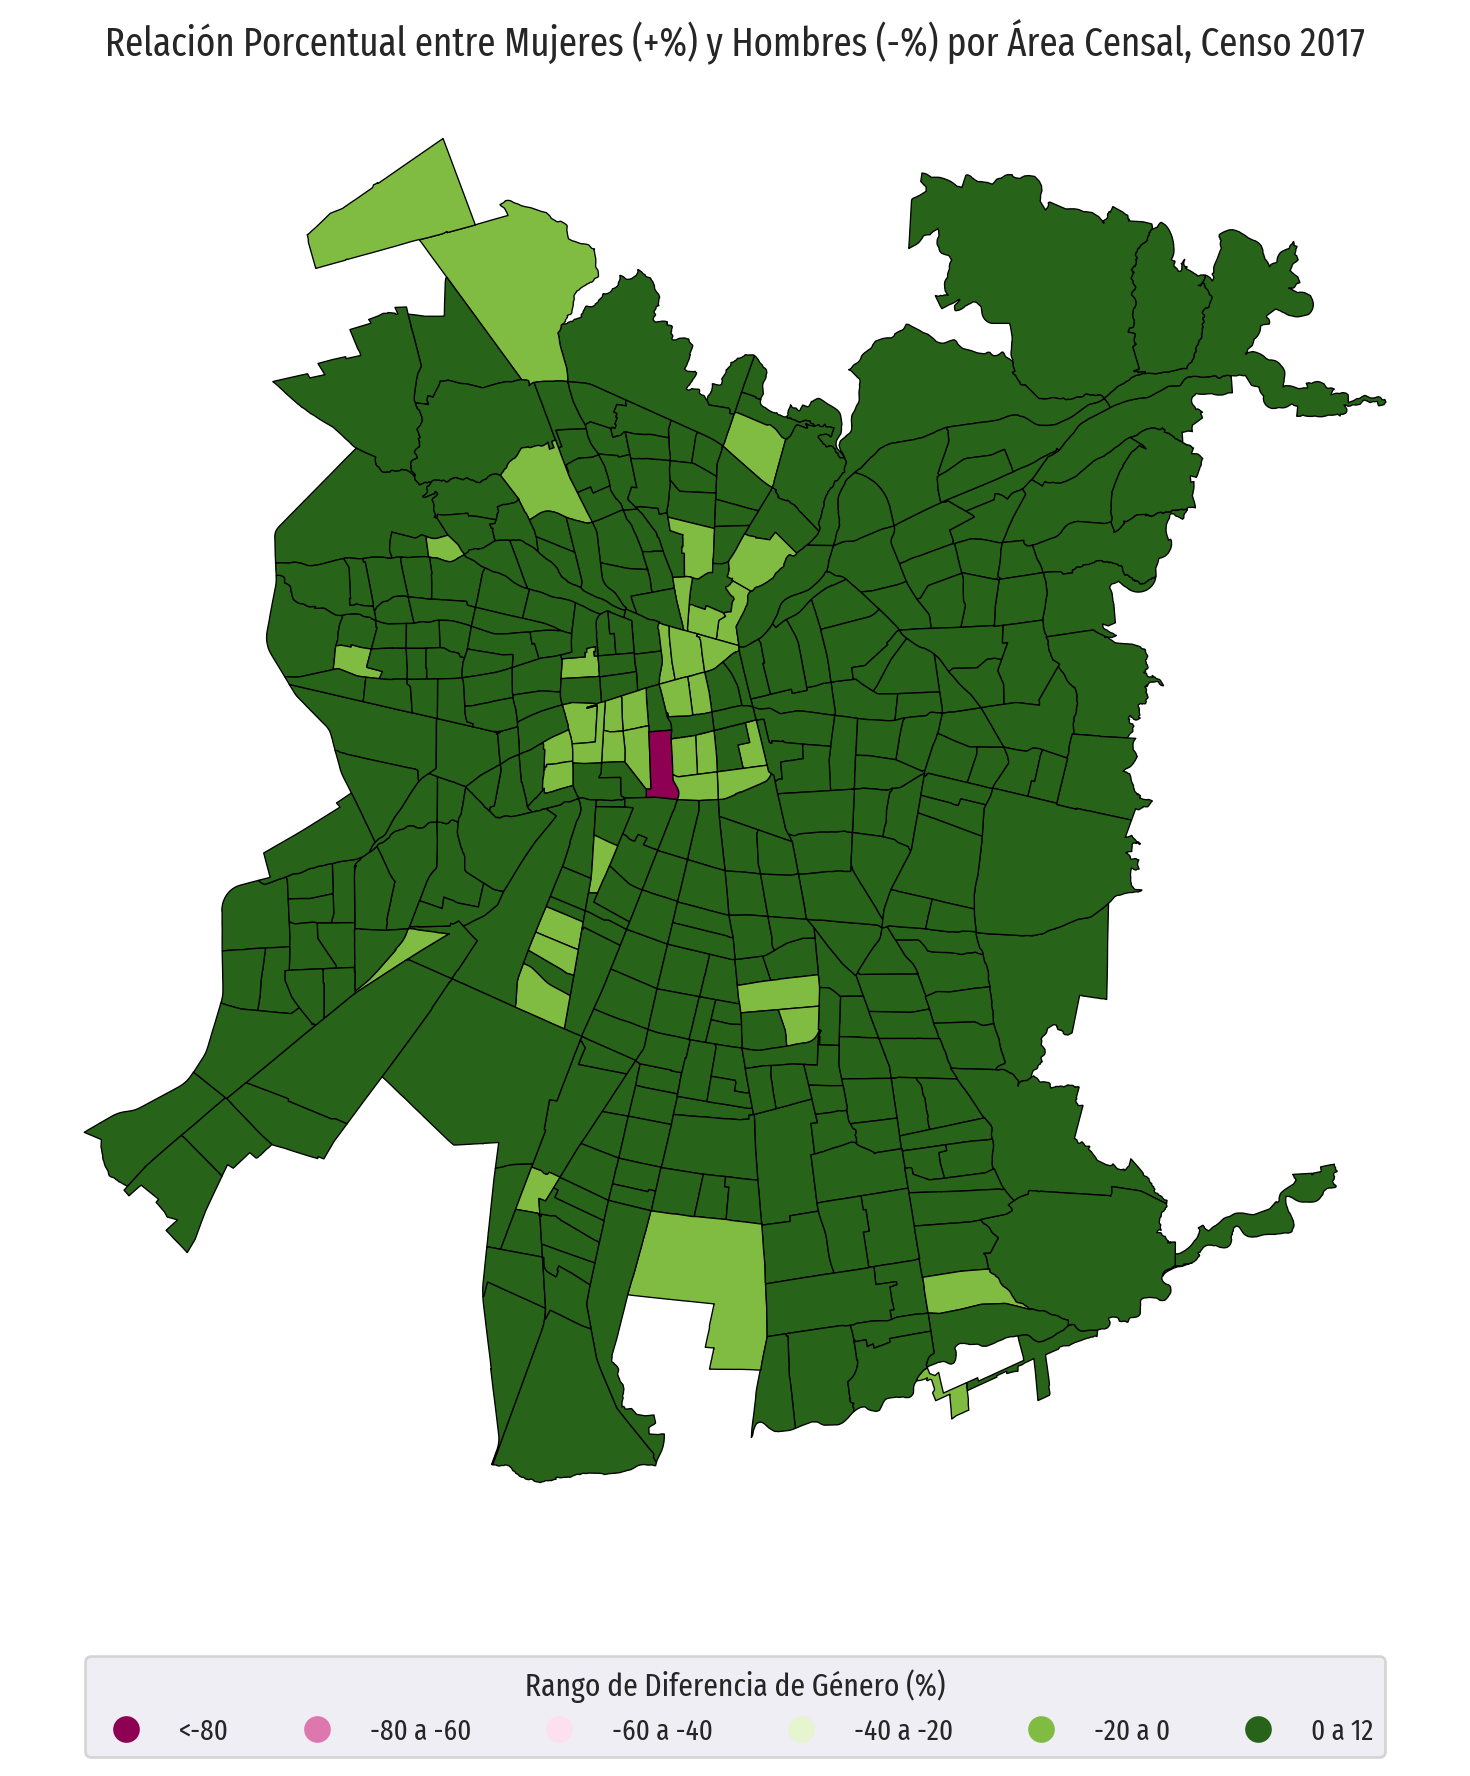

In [35]:
import matplotlib.colors as mcolors


# Calcular el ratio de diferencia de género como porcentaje
urban_data['RATIO'] = ((urban_data['MUJERES'] - urban_data['HOMBRES']) / urban_data['POPULATION']) * 100

# Definir los bins manualmente
bins = [-90,-80,-60, -40, -20, 0, 12]
labels = ["<-80", "-80 a -60", "-60 a -40", "-40 a -20", "-20 a 0", "0 a 12"]

# Discretizar la columna 'RATIO' usando los bins y las etiquetas
urban_data['RATIO_CAT'] = pd.cut(urban_data['RATIO'], bins=bins, labels=labels, include_lowest=True)

# Crear una paleta de colores personalizada
cmap = plt.get_cmap('PiYG', 6)  # Ajustar la cantidad de colores a la cantidad de labels

# Dibujar el gráfico de cloropletas
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
divider = urban_data.plot(column='RATIO_CAT', ax=ax, legend=True,
                          cmap=cmap, edgecolor='black', linewidth=0.5,
                          legend_kwds={'title': "Rango de Diferencia de Género (%)", 'loc': 'lower center', 'bbox_to_anchor': (0.5, -0.15), 'ncol': len(labels)})

# Agregar título y ajustes adicionales
ax.set_title("Relación Porcentual entre Mujeres (+%) y Hombres (-%) por Área Censal, Censo 2017", fontsize=15)
ax.set_axis_off()  # Opcional: elimina los ejes para una visualización más limpia

plt.show()

### Interpretación:

Observamos que en la mayoría de los distritos de la ciudad, la diferencia porcentual entre mujeres y hombres, respecto a la población total, varía entre el 0% y el 20% a favor de las mujeres. En los distritos donde los hombres son mayoría, esta diferencia porcentual no supera el 20%, excepto en un distrito particular, que es donde se encuentra la penitenciaría de Santiago, donde el ratio asciende a más del 80% a favor de los hombres.